In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pickle

In [3]:
import os

In [4]:
path = os.getcwd()
df = pd.read_csv(path+"/data/train.csv")
stores = pd.read_csv(path+"/data/stores.csv")
test = pd.read_csv(path+"/data/test.csv")
df.date = pd.to_datetime(df.date)

In [ ]:
df.head()

In [ ]:
stores.head()

In [10]:
stores.store_nbr.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [8]:
df.shape

(3000888, 6)

In [9]:
df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [ ]:
df.date.dtype

In [5]:
start = pd.Timestamp(2015,1,1,0)
end = pd.Timestamp(2016,1,1,0)

In [ ]:
df.head()

In [ ]:
df.date.min()

In [ ]:
df.date.max()

In [ ]:
df.onpromotion.min()

In [ ]:
df.onpromotion.max()

In [ ]:
df.sales.max()

# Preprocessing

## Removing missing data

There is no missing data in the train dat set.

In [6]:
df.isnull().any(axis = 1).any()

False

In [7]:
df.dropna(how='any',inplace=True)
df.shape

(3000888, 6)

## One-hot encoding for catogorical features

make sure you drop one of the category when doing one-hot encoding if you are doing linear regression -- to remove feature collinearity

In [ ]:
df_oh=pd.get_dummies(df, prefix='', prefix_sep='')
df_oh.head()

## Joining store information from stores table

In [ ]:
df = pd.merge(df,stores, how = 'inner', on='store_nbr')
df.head()

In [ ]:
families = list(df.family.unique())

In [ ]:
df.loc[0,'date']

## Removing outlier

let's compare all families of products at store one near earth quake with no promotion to see the effect of the earthquake.

In [ ]:
df[(df['store_nbr']==1)&(df['date']==pd.Timestamp(2014,4,1,0))].shape

In [ ]:
EQ_time = pd.Timestamp(2016,4,16,0)
#end = pd.Timestamp(2016,7,16,0)
#store1_nearEQ = df[(df['store_nbr']==1) & (df['onpromotion']>300.0)&(df['date']>=start)&(df['date']<end)]

In [ ]:
store1_nearEQ.head()

# Exploratory feature analysis

## Explore the impact of the promotions on the product sales

Before going into all the details of seasonality and trends and lags, and adding all the time series features, let's take a look at how other features influence the product sales.

First I want to know what is the trend of sales numbers in each product category and compare it with the promotions.

In [5]:
promo_allT = pd.DataFrame(df.groupby(['family'])['onpromotion'].sum())

In [6]:
promo_allT = promo_allT.reset_index()

In [7]:
sales_allT = pd.DataFrame(df.groupby(['family'])['sales'].sum())

In [8]:
sales_allT = sales_allT.reset_index()

In [9]:
df_allT = pd.merge(promo_allT, sales_allT, how = 'inner', on='family')

In [10]:
df_allT = df_allT.sort_values(by='onpromotion')
df_allT.head()

,family,onpromotion,sales
4,BOOKS,2772.0,6438.0
1,BABY CARE,5294.0,10051.0
17,HOME APPLIANCES,16975.0,41601.0
14,HARDWARE,53827.0,103470.0
31,SCHOOL AND OFFICE SUPPLIES,62415.0,269316.0


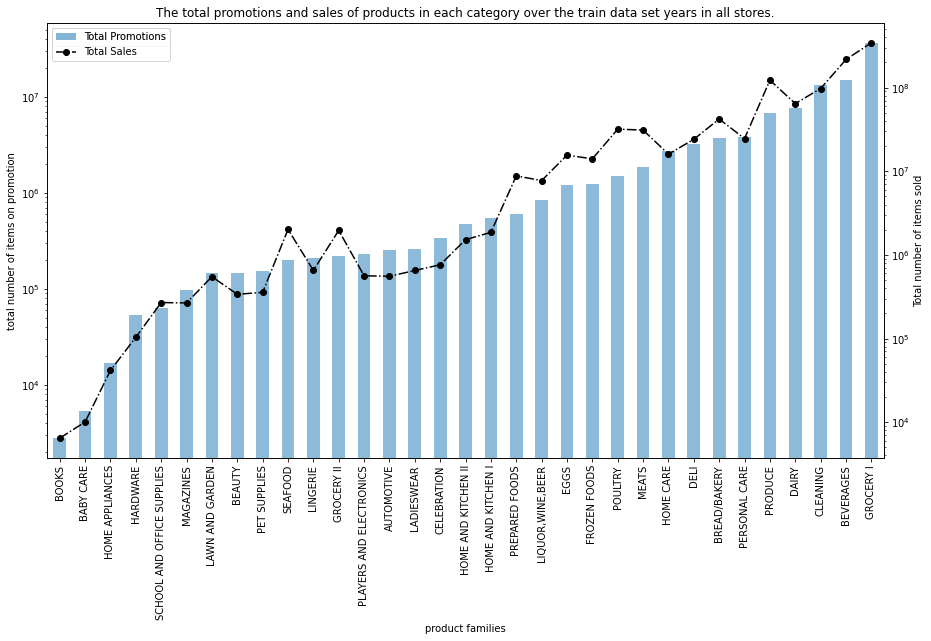

In [11]:
ax = df_allT.plot(kind='bar',figsize=(15,8),x='family',y='onpromotion', alpha = 0.5,label='Total Promotions')
ax.set_xlabel('product families')
ax.set_ylabel('total number of items on promotion')
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(df_allT['family'],df_allT['sales'], marker='o',ls='-.',c='k',label='Total Sales')
ax2.set_ylabel('Total number of items sold')
ax2.set_yscale('log')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.title("The total promotions and sales of products in each category over the train data set years in all stores.")
plt.show()

Seems like that the product categories with more promotions sell better. So does it mean that more promotions lead to more sales, or maybe those popular products naturally get more promotions and exposures?

In [12]:
df_pdist = pd.DataFrame(df.groupby(['date','family'])['onpromotion'].sum()).reset_index()
df_sdist = pd.DataFrame(df.groupby(['date','family'])['sales'].sum()).reset_index()

In [13]:
df_sdist.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.0
1,2013-01-01,BABY CARE,0.0
2,2013-01-01,BEAUTY,2.0
3,2013-01-01,BEVERAGES,810.0
4,2013-01-01,BOOKS,0.0


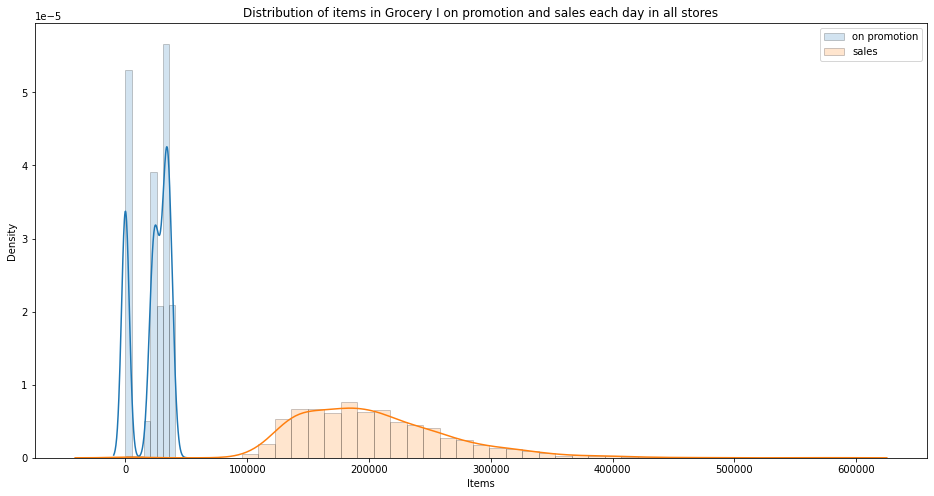

In [14]:
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}

plt.figure(figsize=(16,8))

sns.distplot(df_pdist[df['family'] == 'GROCERY I']['onpromotion'], label='on promotion', hist_kws = hist_kws)
sns.distplot(df_sdist[df['family'] == 'GROCERY I']['sales'], label='sales', hist_kws = hist_kws)
plt.legend()
plt.title('Distribution of items in Grocery I on promotion and sales each day in all stores')
plt.xlabel('Items');


In [15]:
max5_sold_families = list(df_allT.iloc[-5:,0])
min10_sold_families = list(df_allT.iloc[0:11,0])
eleven2twenty8 = list(df_allT.iloc[11:29,0])

In [ ]:
max5_sold_families

In [ ]:
min10_sold_families

Text(0.5, 0, 'Items')

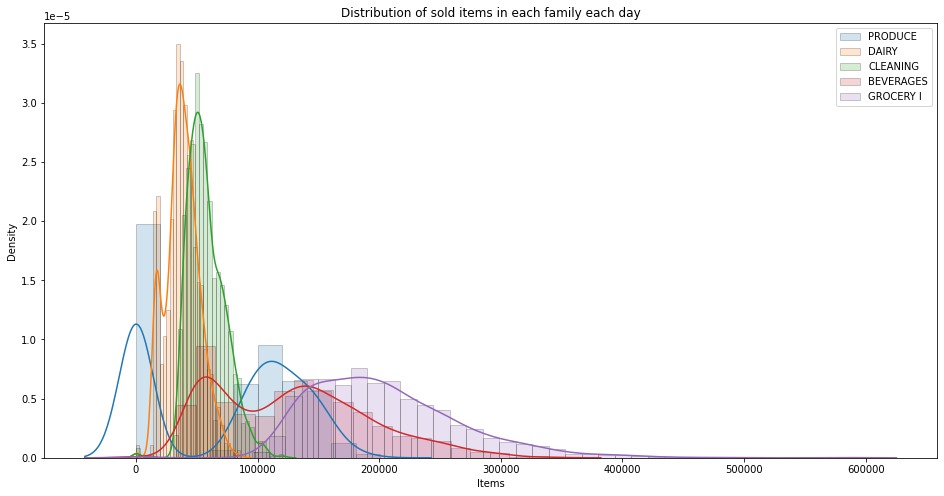

In [16]:
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}

plt.figure(figsize=(16,8))
for family in max5_sold_families:
    sns.distplot(df_sdist[df['family'] == family]['sales'], label=family, hist_kws = hist_kws)

plt.legend()
plt.title('Distribution of sold items in each family each day')
plt.xlabel('Items')
#plt.xscale('log')

In [ ]:
# df2 = df.copy()
# df2['onpromotion'] = pd.cut(df2['onpromotion'],[0.0,100,200,300,400,500,600,700,800,900,1006.0],include_lowest =True)

In [ ]:
df.head()

In [17]:
mean_sales = pd.DataFrame(df.groupby(['family','onpromotion'])['sales'].mean()).reset_index()

In [18]:
mean_sales.head()

,family,onpromotion,sales
0,AUTOMOTIVE,0.0,3.815307
1,AUTOMOTIVE,1.0,1.430927
2,AUTOMOTIVE,2.0,2.983124
3,AUTOMOTIVE,3.0,4.572786
4,AUTOMOTIVE,4.0,6.274716


From the plots below, we can see that there exists some quadratic input-output relationshoip between promotions and sales. But for each product family, the coefficients differ. So if I would like to do some feature transformation to include this information, at least in linear models, only adding quadratic terms of promotions is not enough. I also need to add interactive features of promotions and product category feature. But How? Maybe not linear model... Maybe binning the promotion feature is a more practical and better approach...

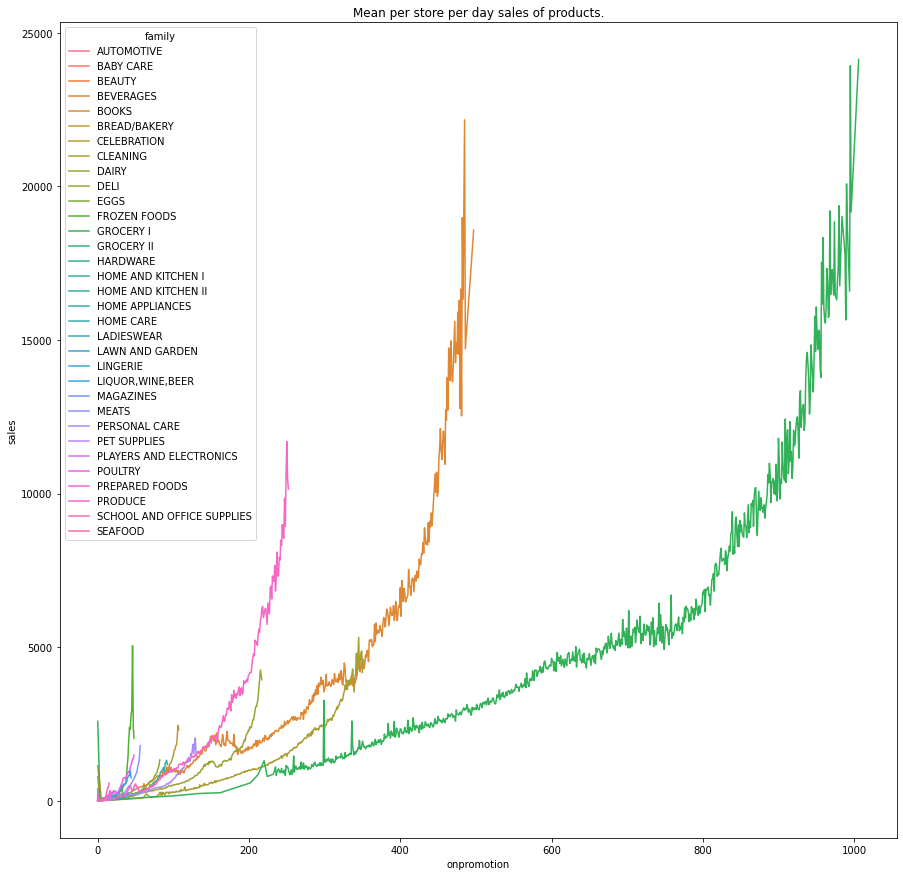

In [19]:
fig,ax = plt.subplots(figsize=(15,15))
sns.lineplot(data=mean_sales, x="onpromotion", y="sales", hue="family")
plt.title('Mean per store per day sales of products.')
plt.show()

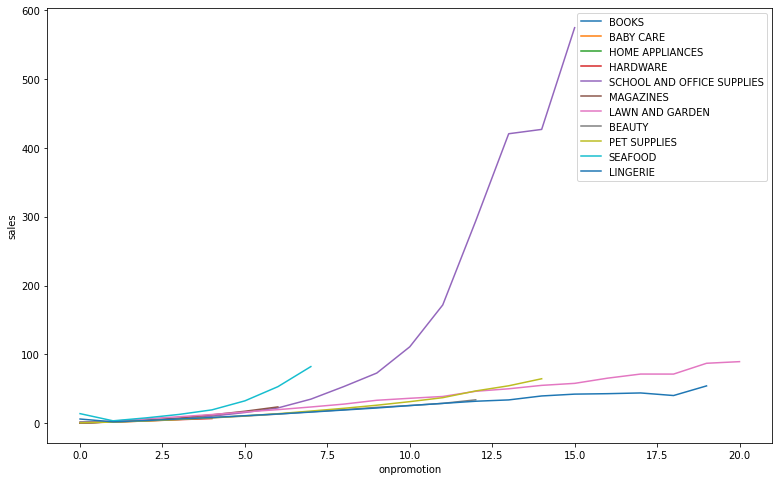

In [20]:
fig,ax = plt.subplots(figsize=(13,8))
for family in min10_sold_families:
    sns.lineplot(data=mean_sales[mean_sales['family']==family], x="onpromotion", y="sales",label=family)
plt.legend()
plt.show()


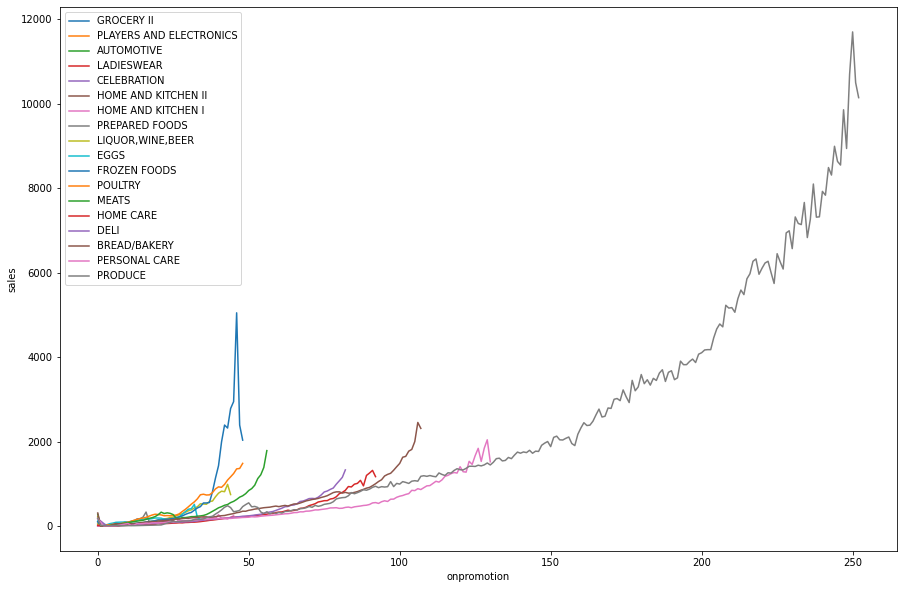

In [21]:
fig,ax = plt.subplots(figsize=(15,10))
for family in eleven2twenty8:
    sns.lineplot(data=mean_sales[mean_sales['family']==family], x="onpromotion", y="sales",label = family)
plt.legend()
plt.show()

## let me see whether there is lagged response of promotions on sales

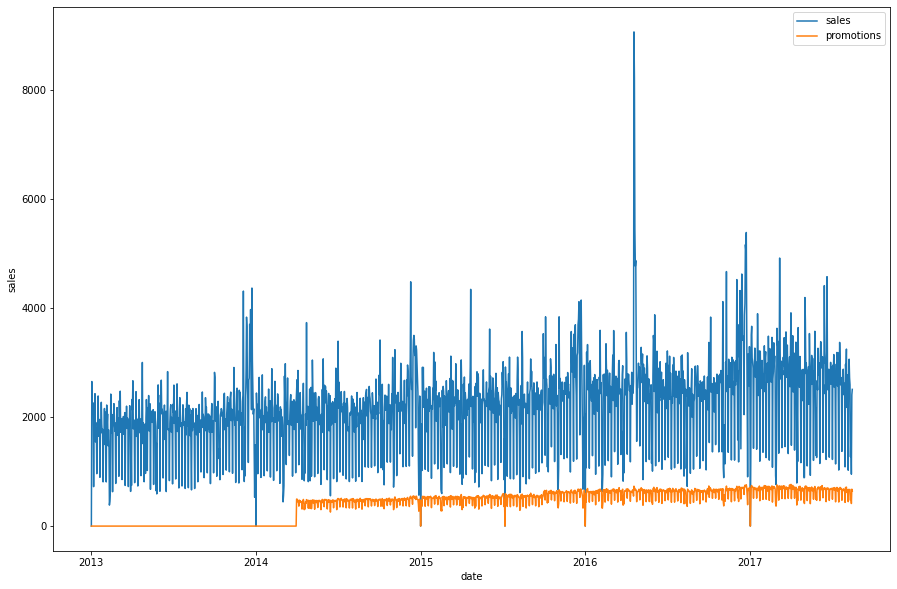

In [22]:
fig,ax = plt.subplots(figsize=(15,10))
sns.lineplot(data=df[(df['family']=='GROCERY I') & (df['store_nbr']==1)], x="date", y="sales", label = 'sales')
sns.lineplot(data=df[(df['family']=='GROCERY I') & (df['store_nbr']==1)], x="date", y="onpromotion", label = 'promotions')
plt.legend()

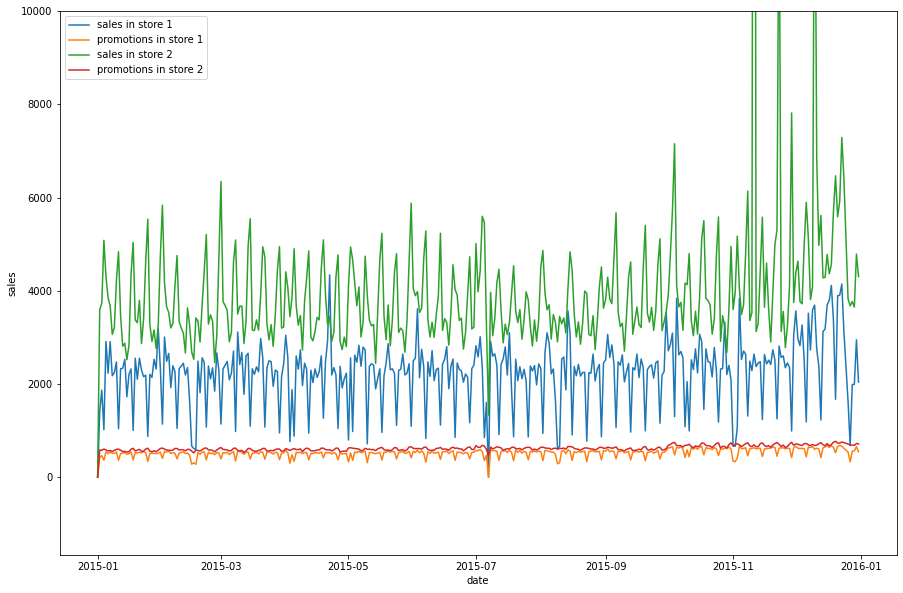

In [23]:
fig,ax = plt.subplots(figsize=(15,10))
subdf = df[(df['family']=='GROCERY I') & (df['store_nbr']==1) & (df['date']>=start) & (df['date']<end)]
subdf2 = df[(df['family']=='GROCERY I') & (df['store_nbr']==2) & (df['date']>=start) & (df['date']<end)]
sns.lineplot(data=subdf, x="date", y="sales", label = 'sales in store 1')
sns.lineplot(data=subdf, x="date", y="onpromotion", label = 'promotions in store 1')
sns.lineplot(data=subdf2, x="date", y="sales", label = 'sales in store 2')
sns.lineplot(data=subdf2, x="date", y="onpromotion", label = 'promotions in store 2')
plt.legend()
ax.set_ylim(ymax=10000)
plt.show()

In [ ]:
test.head()

# Creating features for linear regression

Things I need to do:
* Binning onpromotion
* Turn Store_nbr into string 
* One-hot Encoding
* Trend Term : Linear
* Seasonlality terms : Fourier Features; Make seasonal plots and periodograms to see the frequency
* Serial Dependence Term (Lag terms)

To start with, I will first focusing on GROCERY I, assuming trend and seasonality for all family categories are the same

In [6]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram

In [7]:
df = df[df['date']< end]

In [8]:
df = df.set_index("date").to_period("D")
df = df.drop(columns=['id'])

In [10]:
df['onpromotion']=pd.cut(df['onpromotion'],5,include_lowest =True)

In [11]:
df['store_nbr'] = df[['store_nbr']].astype(str)

In [12]:
df = pd.get_dummies(df)

In [13]:
df.shape

(1945944, 93)

In [62]:
df.dtypes

sales                         float64
store_nbr_1                     uint8
store_nbr_10                    uint8
store_nbr_11                    uint8
store_nbr_12                    uint8
                               ...   
onpromotion_(352.4, 528.6]      uint8
onpromotion_(528.6, 704.8]      uint8
onpromotion_(704.8, 881.0]      uint8
const                         float64
trend                         float64
Length: 95, dtype: object

In [42]:
df.head()

,sales,store_nbr_1,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,"onpromotion_(-0.882, 176.2]","onpromotion_(176.2, 352.4]","onpromotion_(352.4, 528.6]","onpromotion_(528.6, 704.8]","onpromotion_(704.8, 881.0]"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [14]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(10,8))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [31]:
df.shape

(1945944, 93)

In [15]:
df.head()

,sales,store_nbr_1,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,"onpromotion_(-0.882, 176.2]","onpromotion_(176.2, 352.4]","onpromotion_(352.4, 528.6]","onpromotion_(528.6, 704.8]","onpromotion_(704.8, 881.0]"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Seasonal features

let's look at store 1, GROCERY I and LINGERIE

In [23]:
df_temp = pd.read_csv(path+"/data/train.csv")
df_temp['date'] = pd.to_datetime(df_temp['date'])

df_temp = df_temp[(df_temp['store_nbr']==1) & (df_temp['family']=='GROCERY I') & (df_temp['date']<end)] 
df_temp = df_temp.set_index("date").to_period('D')

In [21]:
df_temp2 = pd.read_csv(path+"/data/train.csv")
df_temp2['date'] = pd.to_datetime(df_temp2['date'])

df_temp2 = df_temp2[(df_temp2['store_nbr']==1) & (df_temp2['family']=='LINGERIE') & (df_temp2['date']<end)] 
df_temp2 = df_temp2.set_index("date").to_period('D')

In [24]:
df_temp = df_temp.drop(columns=['id'])
df_temp2 = df_temp2.drop(columns=['id'])

In [53]:
df_temp.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,GROCERY I,0.0,0.0
2013-01-02,1,GROCERY I,2652.0,0.0
2013-01-03,1,GROCERY I,2121.0,0.0
2013-01-04,1,GROCERY I,2056.0,0.0
2013-01-05,1,GROCERY I,2216.0,0.0


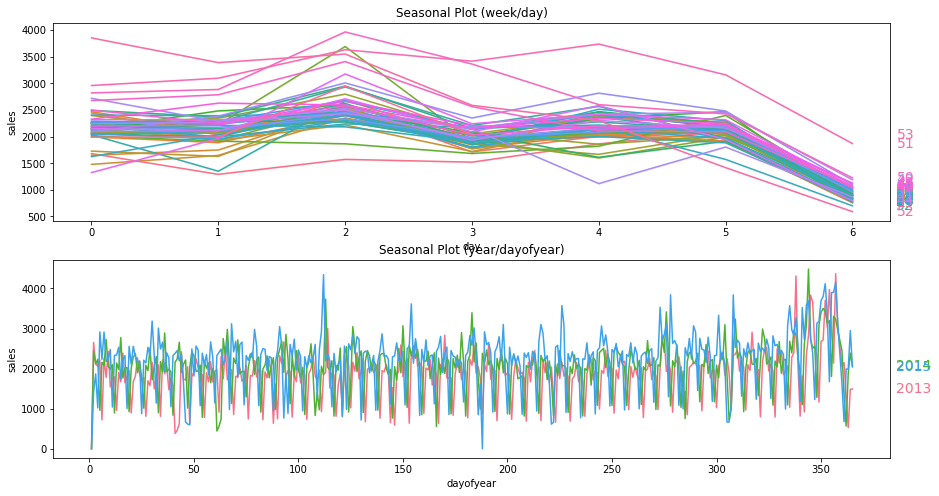

In [57]:
df_temp["day"] = df_temp.index.dayofweek  # the x-axis (freq)
df_temp["week"] = df_temp.index.week  # the seasonal period (period)

# days within a year
df_temp["dayofyear"] = df_temp.index.dayofyear
df_temp["year"] = df_temp.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 8))
seasonal_plot(df_temp, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(df_temp, y="sales", period="year", freq="dayofyear", ax=ax1);

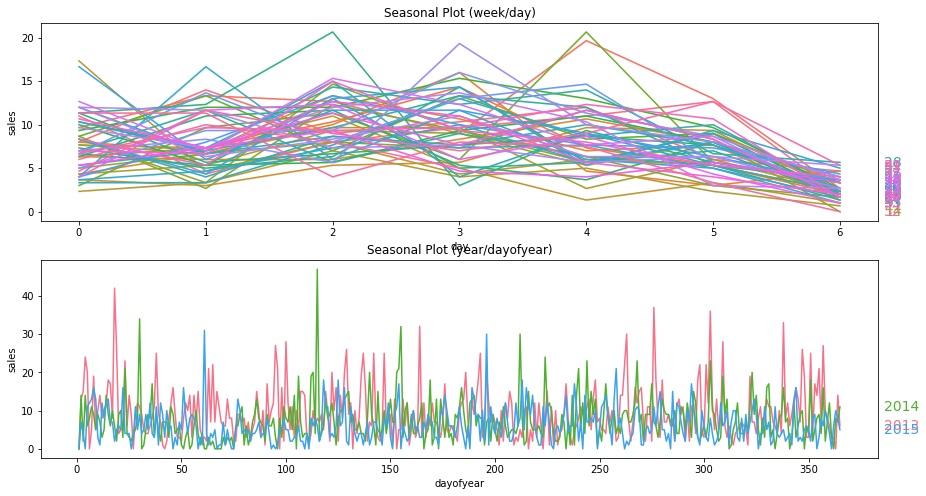

In [25]:
df_temp2["day"] = df_temp2.index.dayofweek  # the x-axis (freq)
df_temp2["week"] = df_temp2.index.week  # the seasonal period (period)

# days within a year
df_temp2["dayofyear"] = df_temp2.index.dayofyear
df_temp2["year"] = df_temp2.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 8))
seasonal_plot(df_temp2, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(df_temp2, y="sales", period="year", freq="dayofyear", ax=ax1);

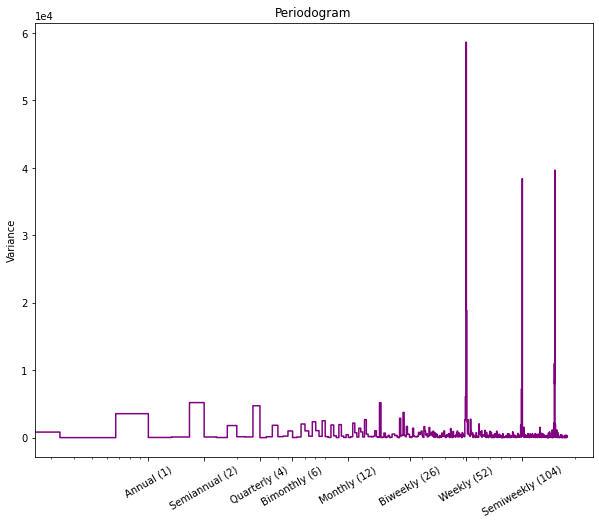

In [61]:
plot_periodogram(df_temp.sales);

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

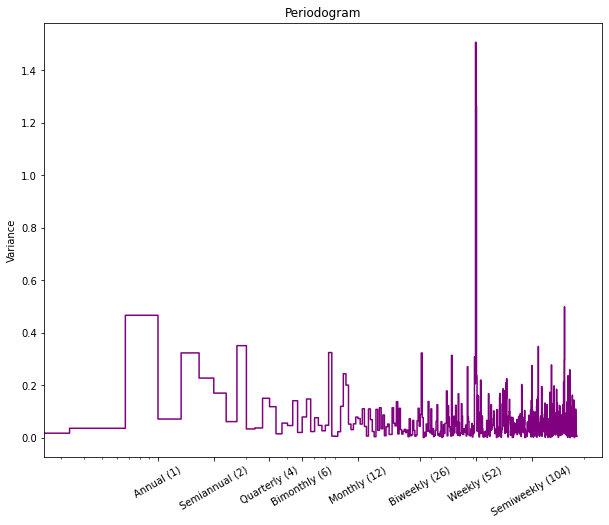

In [26]:
plot_periodogram(df_temp2.sales)

In [15]:
fourier = CalendarFourier(freq="A", order=12)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

In [16]:
X.head(5)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)","sin(11,freq=A-DEC)","cos(11,freq=A-DEC)","sin(12,freq=A-DEC)","cos(12,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2013-01-01,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2013-01-01,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2013-01-01,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2013-01-01,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [21]:
X.shape

(1945944, 32)

In [22]:
df.shape

(1945944, 93)

In [17]:
df = pd.concat([df,X], axis = 1)

In [21]:
df.iloc[:,1:].head()

,store_nbr_1,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,...,"sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)","sin(11,freq=A-DEC)","cos(11,freq=A-DEC)","sin(12,freq=A-DEC)","cos(12,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2013-01-01,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2013-01-01,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2013-01-01,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2013-01-01,1,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [30]:
df.dtypes

sales                 float64
store_nbr_1             uint8
store_nbr_10            uint8
store_nbr_11            uint8
store_nbr_12            uint8
                       ...   
cos(10,freq=A-DEC)    float64
sin(11,freq=A-DEC)    float64
cos(11,freq=A-DEC)    float64
sin(12,freq=A-DEC)    float64
cos(12,freq=A-DEC)    float64
Length: 125, dtype: object

# Base Model - Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

In [24]:
df_test = pd.read_csv(path+"/data/train.csv")
df_test.date = pd.to_datetime(df_test.date)
df_test = df_test[df_test['date']>=pd.Timestamp(2017,1,1,0)]

df_test = df_test.set_index("date").to_period("D")
df_test = df_test.drop(columns=['id'])

df_test['onpromotion']=pd.cut(df_test['onpromotion'],5,include_lowest =True)
df_test['store_nbr'] = df_test[['store_nbr']].astype(str)

df_test = pd.get_dummies(df_test)

fourier = CalendarFourier(freq="A", order=12) 

dp = DeterministicProcess(
    index=df_test.index,
    constant=True,              
    order=1,                     
    seasonal=True,               
    additional_terms=[fourier], 
    drop=True,                   
)

X = dp.in_sample()  
df_test = pd.concat([df_test,X], axis = 1)

In [25]:
df_test.head()

,sales,store_nbr_1,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,...,"sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)","sin(11,freq=A-DEC)","cos(11,freq=A-DEC)","sin(12,freq=A-DEC)","cos(12,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2017-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2017-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2017-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2017-01-01,0.0,1,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [ ]:
base_model = LinearRegression(fit_intercept=False)
base_model.fit(df.iloc[:,1:], df.iloc[:,0])